In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, mean_squared_error, mean_absolute_error, confusion_matrix
import torch
from torch import nn
import torch.optim as optim

# 1) Загрузка данных, очистка пропусков

In [16]:
data = pd.read_csv("train.csv", sep=',')

print("всего пропусков:", data.isna().sum().sum())
data.head()

# Пропусков нет, очищать не нужно

всего пропусков: 0


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,75516,1731.4840,411.7352,245.7620,0.8023,310.0806,0.9148,82546,0.7169,1.6753,0.3165,0.7531,0.0055,0.0033,0.5672,0.9502,1
1,98903,1374.4370,477.2451,269.7676,0.8249,354.8622,0.9585,103181,0.7679,1.7691,0.6579,0.7436,0.0048,0.0027,0.5529,0.9781,0
2,84746,1311.1570,482.7735,235.9040,0.8725,328.4843,0.9121,92914,0.7162,2.0465,0.6195,0.6804,0.0057,0.0028,0.4630,0.9474,1
3,98184,1463.1680,434.3769,292.6472,0.7390,353.5700,0.9543,102890,0.7316,1.4843,0.5763,0.8140,0.0044,0.0030,0.6625,0.9834,0
4,94170,1267.7271,440.1109,278.4162,0.7745,346.2672,0.9643,97656,0.6836,1.5808,0.7363,0.7868,0.0047,0.0030,0.6190,0.9785,0


Разделение на обучающую и тестовые выборки

In [17]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


# 2) Очистка выбросов

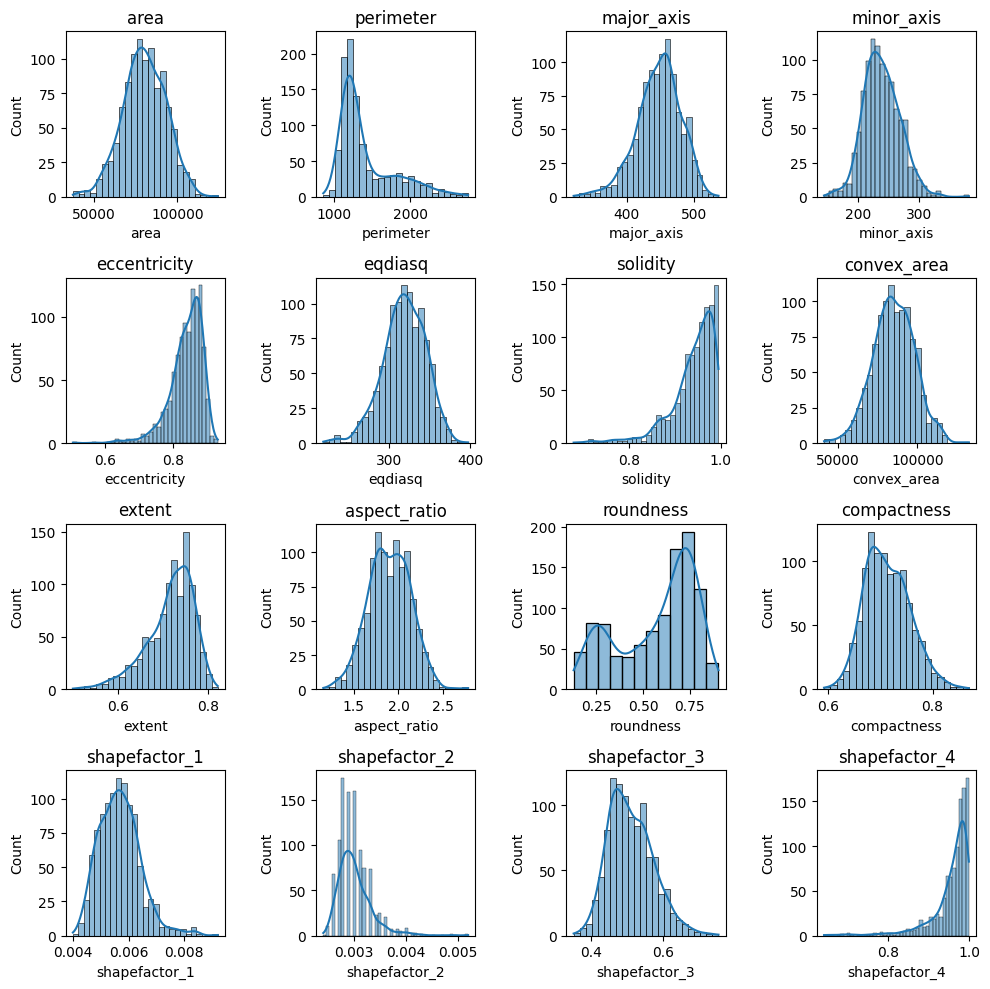

In [18]:
plt.figure(figsize=(10, 10))
features = X_train.columns #очистка только в обучающей 
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(X_train[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()
#график каждого признака, чтобы посмотреть на распределение значений, это нам
#  нужно чтобы понять, какой метод очистки выбросов использовать, есть два 
# сновных метода zscore и iqr, первый используется если признак имеет 
# нормальное распределение, второй для остальных случаев, если посмотреть на 
# графики, то большая часть признаков имеет распределение отличное от нормального.


In [19]:
X_train_cleaned = X_train.copy()

for feature in features:
    Q1 = X_train_cleaned[feature].quantile(0.25)
    Q3 = X_train_cleaned[feature].quantile(0.75)
    IQR = Q3 - Q1
    multiplier = 1.5
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    X_train_cleaned.loc[
        (X_train_cleaned[feature] < lower_bound) | (X_train_cleaned[feature] > upper_bound),
        feature
    ] = np.nan

# Удаляем строки с выбросами
rows_before = len(X_train)
X_train_cleaned.dropna(inplace=True)
y_train = y_train.loc[X_train_cleaned.index]
print(f"Удалено выбросов: {rows_before - len(X_train_cleaned)}")

#очистка выбросов методом iqr так как много признаков с не нормальным распределением

Удалено выбросов: 171


# 3) Нормализация данных и разбиение выборки

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test)  # Тест нормализуем по обучающей выборке

# Преобразуем в тензоры
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)


# 4) Обучение модели

In [21]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)

set_seed(19)
input_dim = X_train_tensor.shape[1]
model = Classifier(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {loss.item():.4f}')


Эпоха [20/500], Потери: 0.1919
Эпоха [40/500], Потери: 0.1244
Эпоха [60/500], Потери: 0.0985
Эпоха [80/500], Потери: 0.0925
Эпоха [100/500], Потери: 0.0898
Эпоха [120/500], Потери: 0.0877
Эпоха [140/500], Потери: 0.0858
Эпоха [160/500], Потери: 0.0839
Эпоха [180/500], Потери: 0.0820
Эпоха [200/500], Потери: 0.0802
Эпоха [220/500], Потери: 0.0783
Эпоха [240/500], Потери: 0.0764
Эпоха [260/500], Потери: 0.0746
Эпоха [280/500], Потери: 0.0728
Эпоха [300/500], Потери: 0.0710
Эпоха [320/500], Потери: 0.0690
Эпоха [340/500], Потери: 0.0669
Эпоха [360/500], Потери: 0.0647
Эпоха [380/500], Потери: 0.0624
Эпоха [400/500], Потери: 0.0602
Эпоха [420/500], Потери: 0.0578
Эпоха [440/500], Потери: 0.0552
Эпоха [460/500], Потери: 0.0526
Эпоха [480/500], Потери: 0.0499
Эпоха [500/500], Потери: 0.0470


# 5) Анализ эффективности

Точность = 0.8953
Полнота = 0.9085
MSE = 0.1047
MAE = 0.1047


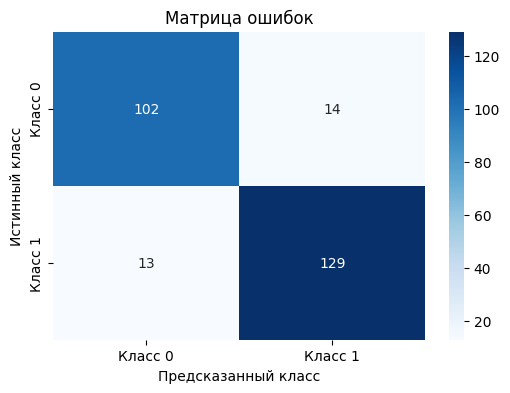

In [22]:
model.eval()
with torch.no_grad():
    predictions_prob = model(X_test_tensor)
    predictions = (predictions_prob > 0.5).float()

    y_test_np = y_test_tensor.numpy()
    predictions_np = predictions.numpy()

    accuracy = accuracy_score(y_test_np, predictions_np)
    recall = recall_score(y_test_np, predictions_np)
    mse = mean_squared_error(y_test_np, predictions_np)
    mae = mean_absolute_error(y_test_np, predictions_np)
    cm = confusion_matrix(y_test_np, predictions_np)

    print(f"Точность = {accuracy:.4f}")
    print(f"Полнота = {recall:.4f}")
    print(f"MSE = {mse:.4f}")
    print(f"MAE = {mae:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Класс 0', 'Класс 1'],
                yticklabels=['Класс 0', 'Класс 1'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()